## Извлекаем данные из файла

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pandas import read_csv
from numpy import *
from pylab import *

import itertools

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
%autosave 180


data = read_csv('data.tsv', sep='\t')
N = shape(data)[0]

Autosaving every 180 seconds


In [4]:
time = array(data['TIMESTAMP'])
print(time[N-1]-time[0], 'sec')
ask_bid = array(data)[:,1:]
shape(time), shape(ask_bid)

17999.80007 sec


((623522,), (623522, 22))

### Визуализируем динамику предложения и спроса
Взяты первые 3 пары колонок

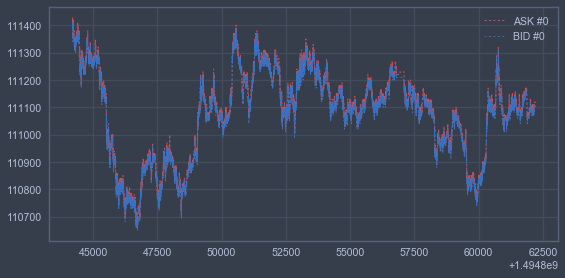

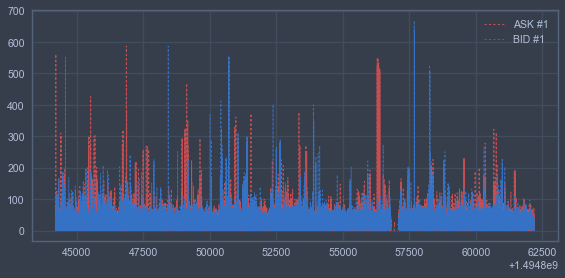

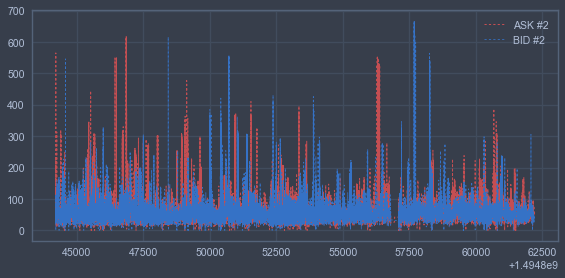

In [5]:
for j in range(3):
    figure()
    plot(time, ask_bid[:,2*j],':',label='ASK #'+str(j),linewidth=1,color='r')
    plot(time, ask_bid[:,2*j+1],':',label='BID #'+str(j),linewidth=0.8)
    legend()
    show()
    
# Замечания:
# 1. Обратим внимание на зазор (вблизи отметки 57500) - пробел в данных?
# 2. Замечаем многочисленные скачки цен - завышения, трактуем как шумы?

## Займёмся первой парой показателей
Посчитаем цену как среднее между ценами спроса и предложения:
\begin{equation}x(t) = \frac{x_{ASK}(t)+x_{BID}(t)}{2}\end{equation}

[ 111365.  111365.  111365. ...,  111105.  111105.  111105.]


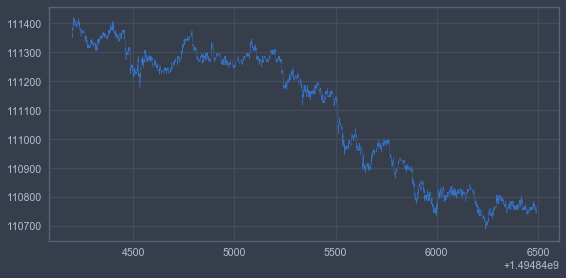

In [6]:
x = sum(ask_bid[:,:2],axis=1)/2
print(x)
shape(x)

t1=100000
figure()
plot(time[:t1],x[:t1],linewidth=0.4)
show()

In [7]:
t = int(1e4) # число узлов (при большем дроблении существенно падает скорость)
moments, step = linspace(time[0], time[-1], num=t, retstep=True)
moments[:9], step

(array([  1.49484420e+09,   1.49484420e+09,   1.49484420e+09,
          1.49484421e+09,   1.49484421e+09,   1.49484421e+09,
          1.49484421e+09,   1.49484421e+09,   1.49484421e+09]),
 1.8001600230070385)

In [8]:
iter_time = nditer(time)
iter_x = nditer(x)
y = []

for m in moments:
    while(iter_time[0] < m):
        iter_time.iternext()
        iter_x.iternext()
    y += [int(iter_x[0])]

In [9]:
y = array(y)
print(y[:10])
print(y[-10:])

[111365 111395 111415 111395 111395 111405 111405 111400 111400 111395]
[111105 111110 111115 111115 111115 111115 111115 111115 111105 111105]


Убедимся, что динамика цен в целом существенно не изменилась

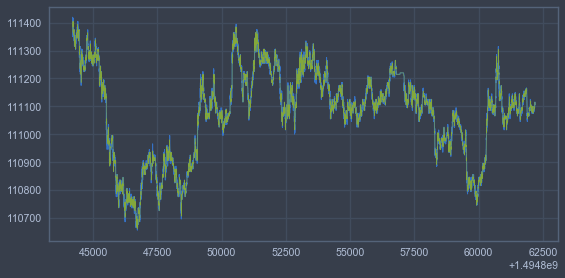

In [10]:
figure()
plot(time,x,linewidth=1)
plot(moments,y,linewidth=0.5)
show()

#### Скомпонуем этот шаг в отдельную функцию

In [11]:
def slice_time(time, values, t=1000, points=False):
    moments, step = linspace(time[0], time[-1], num=t, retstep=True)
    iter_time = nditer(time)
    iter_x = nditer(x)
    y = []

    for m in moments:
        while(iter_time[0] < m):
            iter_time.iternext()
            iter_x.iternext()
        y += [int(iter_x[0])]
    y = array(y)
    
    if points:
        return y,moments
    else:
        return y

### Попытка 1. Линейная модель авторегрессии
Сводим к задаче линейной регрессии. В роли признаков выступают n предыдущих значений ряда:
\begin{equation}y^*_{t}(w) = \sum_{j=0}^{n-1}{w_jy_{t-j}}\end{equation}
В роли объектов $l=t-n$ моментов в истории ряда:

In [12]:
from scipy.linalg import hankel

n = 3000 # Больше – трудности в обращении матрицы
l = t-n+1

F = hankel(y,y)[:l-1,:n]
print(shape(F))

(7000, 3000)


In [13]:
y_train = y[n:]
print(shape(y_train))
print(y_train[:10])
print(y_train[-10:])

(7000,)
[111105 111125 111115 111115 111105 111105 111115 111105 111110 111095]
[111105 111110 111115 111115 111115 111115 111115 111115 111105 111105]


Функционал ошибки (МНК):

\begin{equation}Q_t(w,X^l) = \sum_{i=n}^{t-1}(y^*_i(w)-y_i)^2 = ||Fw-y||^2\end{equation}

Откуда после дифференцирования легко выразить решение в явном виде:

\begin{equation}w = (F^TF)^{-1}F^Ty\end{equation}
  

In [14]:
w = inv(F.T @ F) @ F.T @ y_train

In [15]:
y_reg = vectorize(int)(vectorize(round)(array([y[j:n+j].T @ w for j in range(l)])))
print(y_reg[:10])
print(y_reg[-10:])

[111104 111118 111121 111112 111117 111106 111103 111115 111105 111107]
[111105 111113 111119 111113 111120 111113 111113 111117 111107 111098]


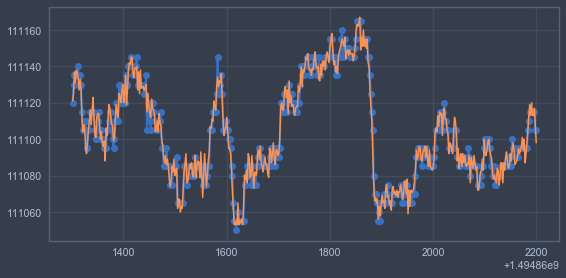

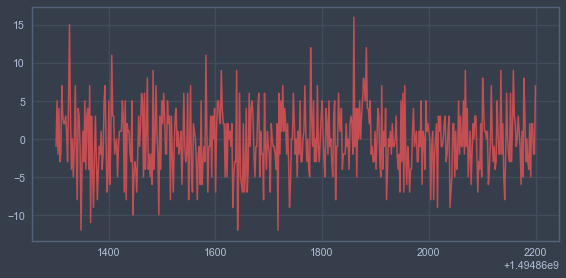

In [16]:
k=500

figure()
plot(moments[-k:],y_train[-k:],'-o',linewidth=2)
plot(moments[-k:],y_reg[-k:],color='y',alpha=1)
show()

figure()
plot(moments[-k:],((y_train[-k:]-y_reg[-k:])),color='r')
show()

# Регрессия и остатки регрессии на последних пятистах моментах времени

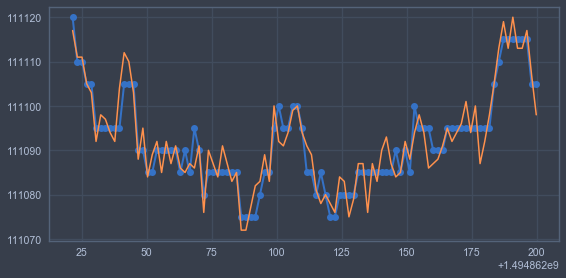

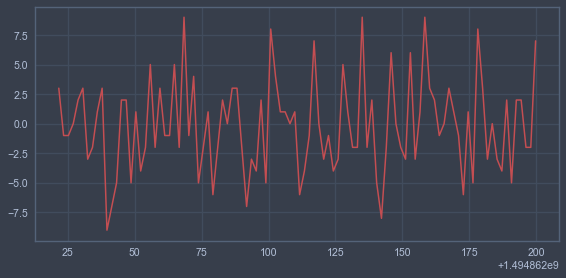

In [17]:
k=100

figure()
plot(moments[-k:],y_train[-k:],'-o',linewidth=2)
plot(moments[-k:],y_reg[-k:],color='y',alpha=1)
show()

figure()
plot(moments[-k:],((y_train[-k:]-y_reg[-k:])),color='r')
show()

# Регрессия и остатки регрессии на последней сотне моментов

Предскажем следующие q моментов времени

In [18]:
y_pred = 1*y

q = 1000
for i in range(q): 
    new_y = y_pred[-n:].T @ w
    y_pred = append(y_pred,[new_y])
    
new_moments = [moments[-1]+step*i for i in range(1,q+1)]

y_pred = vectorize(int)(vectorize(round)(y_pred))
print(y_pred[-q:-q+10])
print(y_pred[-10:])

[111098 111106 111099 111093 111096 111099 111098 111094 111091 111089]
[111169 111165 111175 111170 111177 111178 111176 111187 111186 111183]


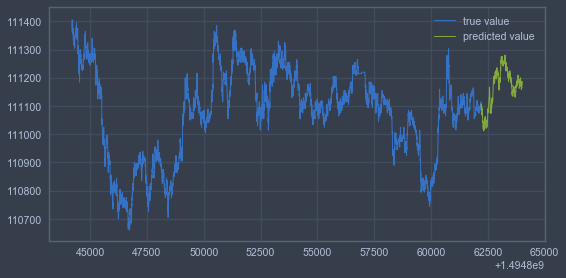

111183 at 1494863999.96


In [19]:
figure()
plot(moments,y_pred[:-q],linewidth=1,label='true value')
plot(new_moments,y_pred[-q:],linewidth=1,label='predicted value')
legend()
show()

print(y_pred[-1],'at',new_moments[-1])
with open('autoreg.csv', 'w', encoding="utf-8") as f:
    f.write('TIMESTAMP\tCOST\n')
    for moment,cost in zip(new_moments,y_pred):
        f.write(str(moment)+'\t'+str(cost)+'\n')


#### Упакуем всю модель в одну функцию


In [20]:
def autoreg(y, moments, n=100, q=30):
    step = moments[1]-moments[0]
    t = len(y)
    l = t-n+1
    F = hankel(y,y)[:l-1,:n]
    
    y_train = y[n:]
    w = inv(F.T @ F) @ F.T @ y_train
    
    y_pred = 1*y
    for i in range(q): 
        new_y = y_pred[-n:].T @ w
        y_pred = append(y_pred,[new_y])
    y_pred = vectorize(int)(vectorize(round)(y_pred))
    new_moments = [moments[-1]+step*i for i in range(1,q+1)]
    
    return list(moments)+list(new_moments),y_pred

In [21]:
t=1000
y,moments = slice_time(time,x,t=t,points=True)

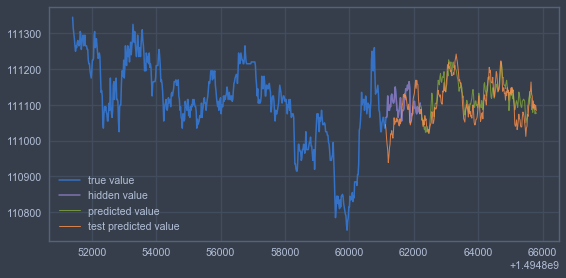

In [22]:
p = 60 # Сколько скрываем
q = 200 # Сколько предсказать
n = 300 # Сложность модели

figure()
moments,y_pred = autoreg(y, moments, n=n, q=0)
plot(moments[-3*q:],y[-3*q:],label='true value')
plot(moments[-p:],y[-p:],label='hidden value',color='m')

moments0,y0_pred = autoreg(y, moments, n=n, q=q)
plot(moments0[-q:],y0_pred[-q:],linewidth=1,label='predicted value',alpha=0.8)

moments1,y1_pred = autoreg(y[:-p], moments[:-p], n=n, q=p+q)
plot(moments1[-q-p-1:],y1_pred[-q-p-1:],'y',linewidth=1,label='test predicted value',alpha=0.8)
legend()
show()

In [23]:
moments[1]-moments[0] # Шаг

18.017817974090576

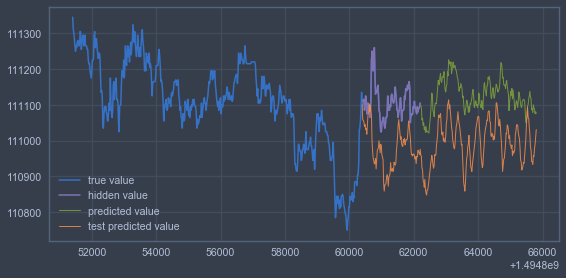

In [24]:
p = 100 # Сколько скрываем
q = 200 # Сколько предсказать
n = 300 # Сложность модели

figure()
moments,y_pred = autoreg(y, moments, n=n, q=0)
plot(moments[-3*q:],y[-3*q:],label='true value')
plot(moments[-p:],y[-p:],label='hidden value',color='m')

moments0,y0_pred = autoreg(y, moments, n=n, q=q)
plot(moments0[-q:],y0_pred[-q:],linewidth=1,label='predicted value',alpha=0.8)

moments1,y1_pred = autoreg(y[:-p], moments[:-p], n=n, q=p+q)
plot(moments1[-q-p-1:],y1_pred[-q-p-1:],'y',linewidth=1,label='test predicted value',alpha=0.8)
legend()
show()

### Попытка 2. Экспоненциальное скользящее среднее (ЭСС)
Сводим к задаче линейной регрессии. В роли признаков выступают n предыдущих значений ряда:

\begin{equation}y^*_{t}(\alpha) = y^*_{t-1}+\alpha (y_{t-1}-y^*_{t-1})\\ \alpha \in (0,1)\end{equation}

В роли объектов $l=t-n$ моментов в истории ряда:

In [25]:
conv = lambda x1,x2,a: x1 + a*(x2-x1)

def ema(y,alpha):
    '''Exponential Moving Average'''
    ya = [y[0]]
    for x in y[1:]:
        ya += [conv(ya[-1], x, alpha)]
    return ya

In [26]:
t=1000
y,moments = slice_time(time,x,t=t,points=True)
step=moments[1]-moments[0]
step

18.017817974090576

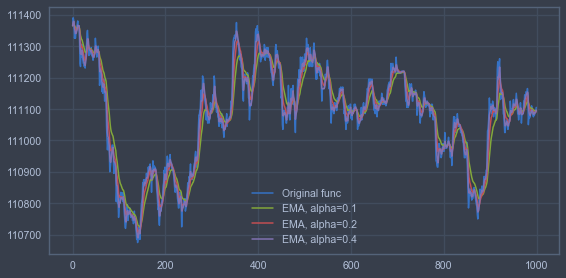

In [27]:
figure()
plot(y,label='Original func')
for a in [0.1,0.2,0.4]:
    plot(ema(y,a),label='EMA, alpha='+str(a))
legend()
show()

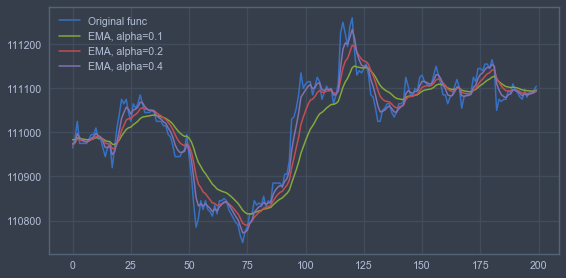

In [28]:
t0 = int(t/5)
figure()
plot(y[-t0:],label='Original func')
for a in [0.1,0.2,0.4]:
    plot(ema(y,a)[-t0:],label='EMA, alpha='+str(a))
legend()
show()

Итак, имеется несколько способов продолжить ряд посредством скользящего среднего. Какой из них будет являться для нас наиболее привлекательным? Как подобрать параметр сглаживания? Для корректной постановки задачи выберем $\alpha^*$, доставляющий минимум функционалу ошибки следующего вида:

\begin{equation}Q(\alpha) = \frac{1}{t}\sum_{i=0}^{t-1}{(y^*_i(\alpha)-y_i)^2}\end{equation}

In [29]:
def EMA_error(y,alpha):
    ya = ema(y,alpha)
    return sum((y-ya)**2)/t

In [30]:
print(EMA_error(y,0.2))
print(EMA_error(y,0.4))
print(EMA_error(y,0.6))
print(EMA_error(y,0.8))

1127.93186209
361.447561396
123.142092364
26.9854119367


Наблюдаем монотонное снижение ошибки с ростом $\alpha$, из чего делаем вывод, что ряд нестационарен и приближать его экспоненциальным скользящим средним (в изложенном выше варианте) не имеет смысла.

В противном случае метод вырождается в тривиальный прогноз $y^*_t=y_{t-1}$.



In [31]:
# Выпишем  прогноз для alpha=0.2
d = 20
new_moments = [moments[-1] + step*(i+1) for i in range(d)]
y_pred = [int(round(ema(y,a)[-1]))]*d

with open('ema.csv', 'w', encoding="utf-8") as f:
    f.write('TIMESTAMP\tCOST\n')
    for moment,cost in zip(new_moments,y_pred):
        f.write(str(moment)+'\t'+str(cost)+'\n')

### Попытка 3. Адаптивные модели с трендом и сезонностью

#### Модель Хольта (линейный тренд без сезонных эффектов):

\begin{equation}y^*_{t+d} = a_t+b_td,\end{equation}

где $a_t$, $b_t$ – адаптивные коэффициенты линейного тренда.

Рекуррентные формулы: 

\begin{equation}a_t=\alpha y_t+(1-\alpha)(a_{t-1}+b_{t-1})\\ 
b_t=\beta (a_t-a_{t-1})+(1-\beta)b_{t-1}\end{equation}

In [39]:
t=1000
y,moments = slice_time(time,x,t=t,points=True)
step = moments[1]-moments[0]
step

18.017817974090576

In [33]:
def holt(y,alpha,beta,d=1):
    a,b = [y[0]],[y[1]-y[0]]
    yd = [y[0]]
    for val in y[1:]:
        a += [alpha*val + (1-alpha)*(a[-1]+b[-1])]
        b += [beta*(a[-1]-a[-2]) + (1-beta)*b[-1]]
        yd += [a[-1]+b[-1]]
    yd += [a[-1]+b[-1]*(i+1) for i in range(d)]
    return yd

Выпишем аналогичный предыдущему функционал ошибки, найдём минимум.

\begin{equation}Q(\alpha,\beta) = \frac{1}{t}\sum_{i=0}^{t-1}{(y^*_i(\alpha,\beta)-y_i)^2}\end{equation}

In [34]:
def Holt_error(y,alpha,beta):
    yab = holt(y,alpha,beta,0)
    t = len(y)
    return sum((y-yab)**2)/t

In [35]:
for a in range(1,5):
    for b in range(1,5):
        print('[a=%s][b=%s]' % (a/5,b/5),end=' ')
        print(Holt_error(y,a/5,b/5),end=' ')
    print()

[a=0.2][b=0.2] 1240.94568656 [a=0.2][b=0.4] 1255.85148119 [a=0.2][b=0.6] 1205.38514015 [a=0.2][b=0.8] 1164.3171093 
[a=0.4][b=0.2] 399.749132314 [a=0.4][b=0.4] 414.116960457 [a=0.4][b=0.6] 436.459276082 [a=0.4][b=0.8] 470.229330149 
[a=0.6][b=0.2] 160.688458413 [a=0.6][b=0.4] 195.209367937 [a=0.6][b=0.6] 235.711269873 [a=0.6][b=0.8] 283.282940182 
[a=0.8][b=0.2] 75.6221507104 [a=0.8][b=0.4] 130.002383707 [a=0.8][b=0.6] 195.382777774 [a=0.8][b=0.8] 274.833889174 


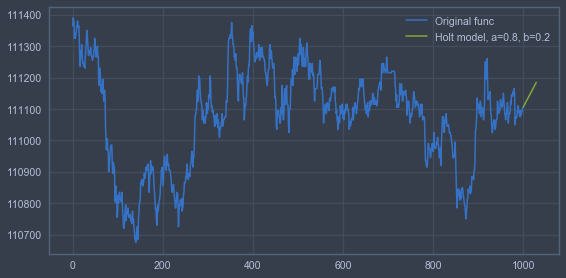

In [233]:
# Минимум на a=0.8, b=0.2
a,b = 0.8,0.2
d = 30
yd = holt(y,a,b,d)

figure()
plot(range(t),y,label='Original func')
plot(range(t,t+d),yd[-d:],label='Holt model, a=%s, b=%s' % (a,b))
legend()
show()

new_moments = [moments[-1] + step*(i+1) for i in range(d)]
y_pred = vectorize(int)(vectorize(round)(yd[-d:]))
with open('holt.csv', 'w', encoding="utf-8") as f:
    f.write('TIMESTAMP\tCOST\n')
    for moment,cost in zip(new_moments,y_pred):
        f.write(str(moment)+'\t'+str(cost)+'\n')
        
# Модель выявила тенденцию к росту

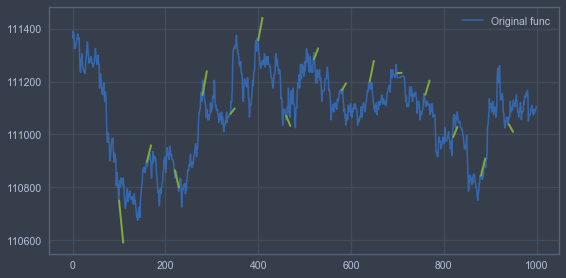

In [37]:
d = 10 # длина прогноза

figure()
plot(range(t),y,label='Original func',alpha=0.8)

for p in [60*i for i in range(1,16)]:
    yp = holt(y[:-p],0.6,0.2,d)
    plot([t-p,t-p+d-1],[yp[-d],yp[-1]],"-",linewidth=2,color='g')
legend()
show()

#### Модель Тейла-Вейджа (линейный тренд с аддитивной сезонностью):

\begin{equation}y^*_{t+d} = (a_t+b_td) + \theta_{t-s+(d\text{ mod }s)}\end{equation}

$(a_t+b_td)$ – тренд без сезонных колебаний;

$\theta_0,..,\theta_{s-1}$ – сезонность периода $s$ без тренда.

Рекуррентные формулы: 

\begin{equation}a_t=\alpha (y_t - \theta_{t-s})+(1-\alpha)(a_{t-1}+b_{t-1})\\ 
b_t=\beta (a_t-a_{t-1})+(1-\beta)b_{t-1}\\
\theta_t=\gamma (y_t-a_t)+(1-\gamma)\theta_{t-s}\end{equation}

$\alpha$, $\beta$, $\gamma$ - параметры сглаживания

In [112]:
t=1000
y,moments = slice_time(time,x,t=t,points=True)
step = moments[1]-moments[0]
step

18.017817974090576

In [224]:
def theil(y,alpha,beta,gamma,theta,d=1):
    s = len(theta)
    iter_theta = nditer(array(theta))
    a,b,c = [y[0]],[y[1]-y[0]],[iter_theta[0]]
    yd = [y[0]]
    for val in y[1:]:
        if len(c) < s:
            c += [iter_theta[0]]
            a += [alpha*(val-c[-1]) + (1-alpha)*(a[-1]+b[-1])]
            b += [beta*(a[-1]-a[-2]) + (1-beta)*b[-1]]
        else:
            a += [alpha*(val-c[-s]) + (1-alpha)*(a[-1]+b[-1])]
            b += [beta*(a[-1]-a[-2]) + (1-beta)*b[-1]]
            c += [gamma*(val-a[-1])+(1-gamma)*c[-s]]
        yd += [a[-1]+b[-1]+c[-1]]
    yd += [a[-1]+b[-1]*(i+1)+c[(i+1)%s-s] for i in range(d)]
    return yd

inrange = lambda l: max(min(l,1),0)

def Theil_error(y,alpha,beta,gamma,theta):
    yt = teil(y,alpha,beta,gamma,theta,d=0)
    t = len(y)
    return sum((y-yt)**2)/t

In [235]:
# Рассмотрим сезонности длиной s0 до s1 "тактов"
s0,s1 = 20,300
tries = 100

# Границы поиска
a0,a1 = 0.0,0.6
b0,b1 = 0.2,1.0
g0,g1 = 0.0,0.5
t0,t1 = -100,100

def theil_opt(y):
    opt_coeff = []
    min_error = 0
    for s in range(s0,s1):
        for k in range(tries):
            coeff = random(s+3)
            alpha = coeff[0]*(a1-a0)+a0
            beta = coeff[1]*(b1-b0)+b0
            gamma = coeff[2]*(g1-g0)+g0
            theta = coeff[3:]*(t1-t0)+t0
            theta = list(theta)
            error = Theil_error(y,alpha,beta,gamma,theta)
            if opt_coeff:
                if error < min_error:
                    opt_coeff = [alpha,beta,gamma]+theta
                    min_error = error
            else:
                opt_coeff = [alpha,beta,gamma]+theta
                min_error = error
    return min_error,opt_coeff
        
min_error,opt_coeff = theil_opt(y)
        
print('min_error:',min_error)
print()
print('alpha='+str(opt_coeff[0]))
print('beta='+str(opt_coeff[1]))
print('gamma='+str(opt_coeff[2]))
print('s='+str(len(opt_coeff[3:])))

min_error: 103.016940846

alpha=0.584691567567
beta=0.212789089662
gamma=0.493919898331
s=94


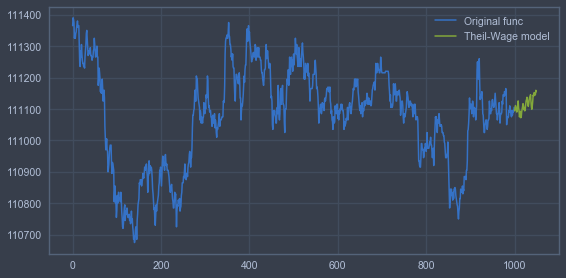

In [236]:
d=50

alpha,beta,gamma,theta = opt_coeff[0],opt_coeff[1],opt_coeff[2],opt_coeff[3:]
yt = theil(y,alpha,beta,gamma,theta,d=d)

figure()
plot(range(t),y,label='Original func')
plot(range(t,t+d),yt[-d:],label='Theil-Wage model')
legend()
show()

new_moments = [moments[-1] + step*(i+1) for i in range(d)]
y_pred = vectorize(int)(vectorize(round)(yd[-d:]))
with open('theil.csv', 'w', encoding="utf-8") as f:
    f.write('TIMESTAMP\tCOST\n')
    for moment,cost in zip(new_moments,y_pred):
        f.write(str(moment)+'\t'+str(cost)+'\n')

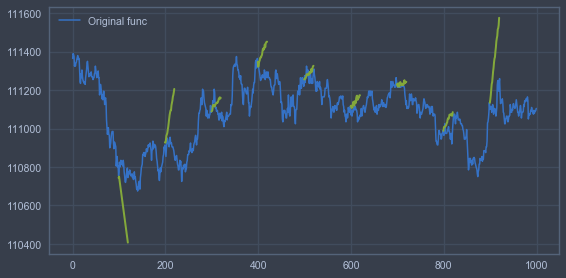

In [248]:
d = 20 # длина прогноза

figure()
plot(range(t),y,label='Original func')

for p in [100*i for i in range(1,10)]:
    yt = theil(y[:-p],alpha,beta,gamma,theta,d=d)
    plot(range(t-p-1,t-p+d),yt[-d-1:],linewidth=2,color='g')
legend()
show()